### Optimal control of deterministic phenomenological models
This notebook shows how to compute the optimal control (OC) signal for phenomenological models (FHN, Hopf) for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.kuramoto import KuramotoModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_kuramoto
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [40]:
# We import the model
model = KuramotoModel()
model.params.omega = np.array([0.])
model.params.k = 0.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 0.4

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,2] = 1.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.params["theta_init"] = np.array([[0.]])

(1, 1, 5)


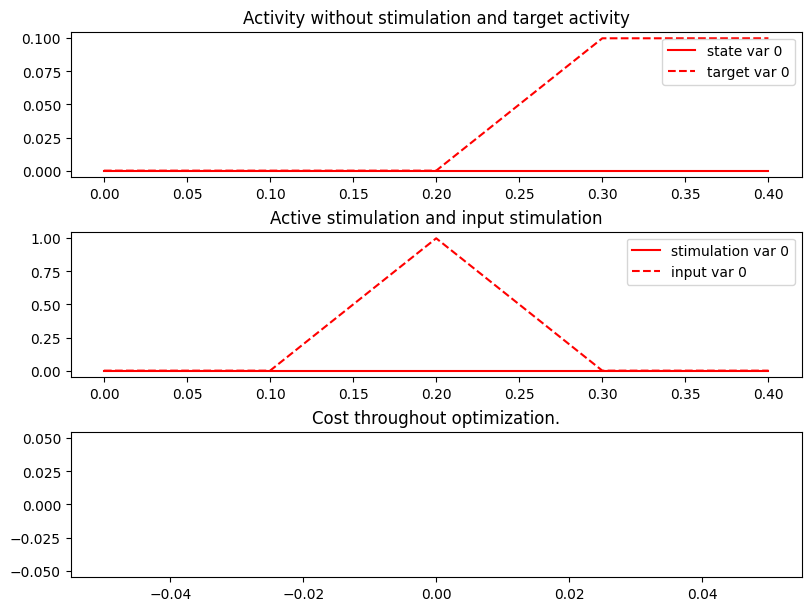

In [41]:
# We set the stimulus in x and y variables, and run the simulation
model.params["theta_ext"] = input
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (model.params["theta_init"][:,:, np.newaxis], model.theta[:, np.newaxis, :]), axis=2)
target_input = input[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["theta_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (model.params["theta_init"][:,:, np.newaxis], model.theta[:, np.newaxis, :]), axis=2)
print(state.shape)

plot_oc_singlenode(duration, dt, state, target, control, target_input, plot_state_vars=[0], plot_control_vars=[0])

Compute control for a deterministic system
Cost in iteration 0: 0.0010000000000000002
Cost in iteration 25: 2.2712705579447057e-05
Cost in iteration 50: 2.2712705579124392e-05
Cost in iteration 75: 2.2712705579124392e-05
Cost in iteration 100: 2.2712705579124392e-05
Final cost : 2.2712705579124392e-05


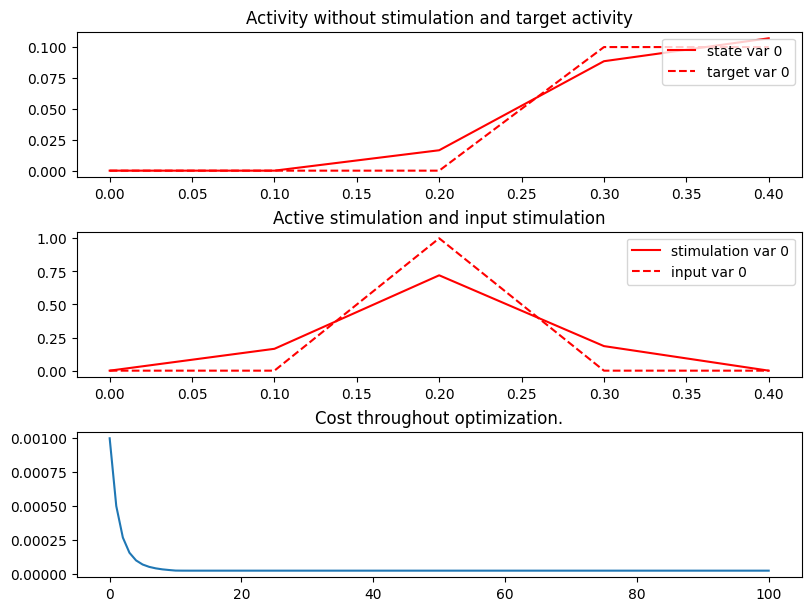

In [42]:
# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["theta_ext"] = zero_input

model_controlled = oc_kuramoto.OcKuramoto(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history, plot_state_vars=[0], plot_control_vars=[0])

Compute control for a deterministic system
Cost in iteration 0: 2.2712705579124392e-05
Converged in iteration 1 with cost 2.2712705579124392e-05
Final cost : 2.2712705579124392e-05


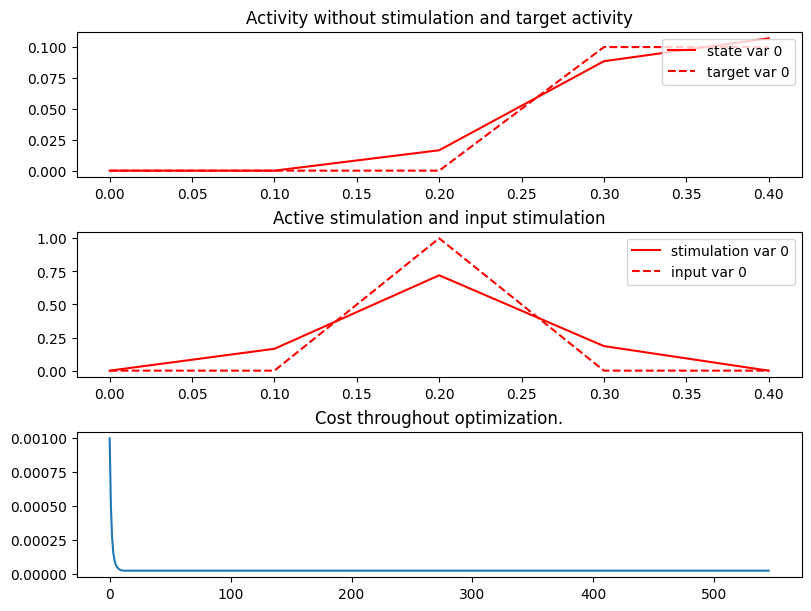

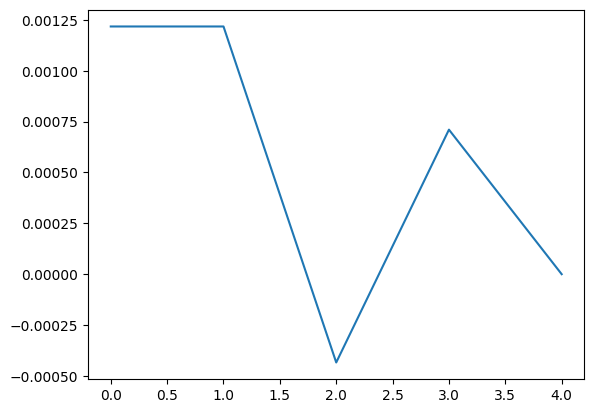

In [47]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.zero_step_encountered = False
model_controlled.step = 1e-6
model_controlled.optimize(1)
state = model_controlled.get_xs()
gradient = model_controlled.gradient
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history, plot_state_vars=[0], plot_control_vars=[0])

plt.plot(gradient[0,0,:])
plt.plot(model_controlled.adjoint_state[0,0,:])
plt.show()